In [1]:
import pandas as pd

In [2]:
data=pd.read_csv(r"C:\Users\Public\project\data\data.csv")

In [3]:
data.head(2)

,Date,Close_EURUSD,High_EURUSD,Low_EURUSD,Open_EURUSD,Volume_EURUSD
0,2015-01-01 00:00:00,1.209863,1.209863,1.209863,1.209863,0
1,2015-01-02 00:00:00,1.208941,1.208956,1.201080,1.208868,0


In [4]:
data['return']=data['Close_EURUSD'].pct_change()

import numpy as np

data['log_return'] = np.log(data['Close_EURUSD'] / data['Close_EURUSD'].shift(1))

data=data.dropna()

data.head()

,Date,Close_EURUSD,High_EURUSD,Low_EURUSD,Open_EURUSD,Volume_EURUSD,return,log_return
1,2015-01-02 00:00:00,1.208941,1.208956,1.201080,1.208868,0,-0.000762,-0.000762
2,2015-01-05 00:00:00,1.194643,1.197590,1.188909,1.195500,0,-0.011827,-0.011897
3,2015-01-06 00:00:00,1.193902,1.197000,1.188693,1.193830,0,-0.000621,-0.000621
4,2015-01-07 00:00:00,1.187536,1.190000,1.180401,1.187479,0,-0.005332,-0.005346
5,2015-01-08 00:00:00,1.183600,1.184806,1.175601,1.183894,0,-0.003314,-0.003320


<Axes: >

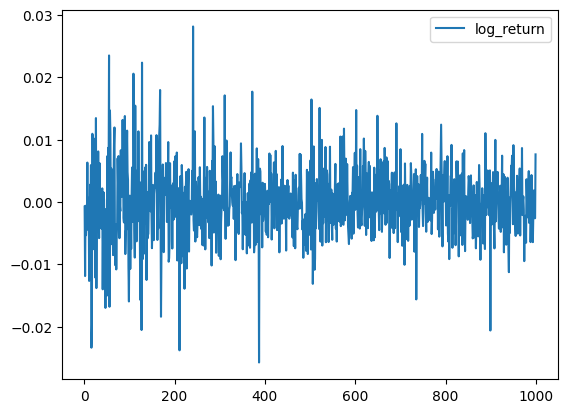

In [5]:
data[['Date','log_return']].plot()



In [6]:
len(data)

999

In [7]:
df=data['log_return']

In [8]:
data['log_return'].mean()

-5.924952197951718e-05

<Axes: xlabel='log_return', ylabel='Count'>

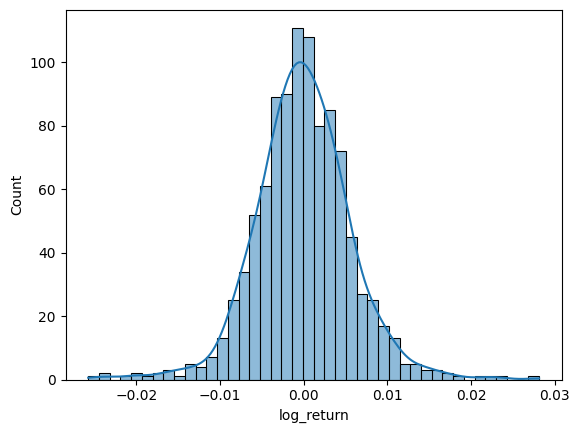

In [9]:
import seaborn as sns
sns.histplot(df,kde=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1add350b280>,
 'caps': [<matplotlib.lines.Line2D at 0x1add3530af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1add3530310>],
 'medians': [<matplotlib.lines.Line2D at 0x1add35310f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1add35313f0>],
 'means': []}

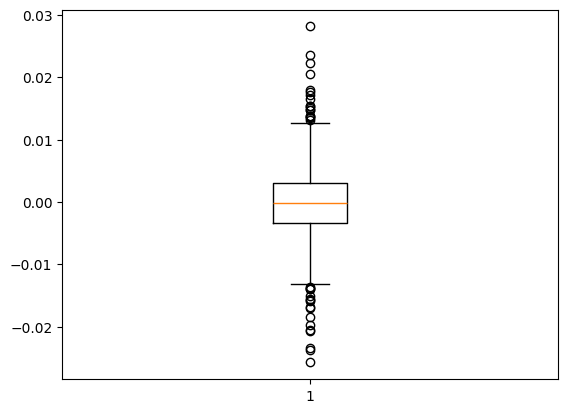

In [10]:
import matplotlib.pyplot as plt

plt.boxplot(df)

In [11]:
# Step 1: Compute Q1, Q3, IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Compute bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out outliers
outlier = df[((df < lower_bound) | (df > upper_bound))]
df_clean = df[(df >= lower_bound) & (df <= upper_bound)]

print(df_clean.dtype)
df_clean=df_clean.reset_index()

df_clean

float64


,index,log_return
0,1,-0.000762
1,2,-0.011897
2,3,-0.000621
3,4,-0.005346
4,5,-0.003320
...,...,...
959,995,0.001833
960,996,-0.001981
961,997,-0.002625
962,998,-0.002618


In [12]:
len(df_clean)

964

In [13]:
len(outlier)

35

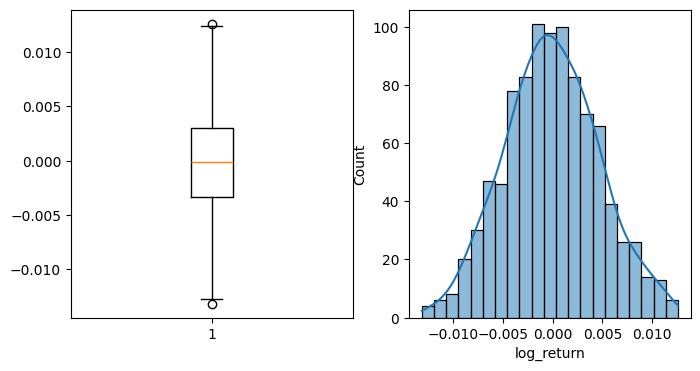

In [14]:
#after outlier removal
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.boxplot(df_clean['log_return'])
plt.subplot(1,2,2)
sns.histplot(df_clean['log_return'],kde=True)
plt.show()

In [15]:
df_clean.head()

,index,log_return
0,1,-0.000762
1,2,-0.011897
2,3,-0.000621
3,4,-0.005346
4,5,-0.003320


In [16]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
data_scaled=scaler.fit_transform(df_clean.values.reshape(-1,1))

In [17]:

data_scaled

array([[-0.78096102],
       [-0.78403802],
       [-0.77788636],
       ...,
       [-0.78404372],
       [ 2.28754602],
       [-0.78401224]])

In [18]:
data_scaled.dtype

dtype('float64')

# Model1: LSTM

In [19]:
X = []
Y = []

input_sequence=10
for i in range(len(data_scaled) - input_sequence):
    X.append(data_scaled[i : i + input_sequence])
    Y.append(data_scaled[i + input_sequence])

X = np.array(X)
Y = np.array(Y)


In [20]:
train_size=int(len(X)*0.7)
val_size=int(len(X)*0.15)
test_size=train_size-val_size

X_train,Y_train=X[:train_size],Y[:train_size]

#test data
X_test,Y_test=X[train_size:train_size+val_size],Y[train_size:train_size+val_size]

#validation data
X_val,Y_val=X[train_size+val_size:],Y[train_size+val_size:]


In [21]:
len(X_train)

1342

In [22]:
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [23]:

n_feature=1
n_input=20



model_LSTM=Sequential()
model_LSTM.add(InputLayer(input_shape=(n_input, n_feature)))
model_LSTM.add(LSTM(45,return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(16))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(3,activation='relu'))
model_LSTM.add(Dense(1,activation='linear'))

C:\Users\elham\anaconda3\envs\torchenv\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
early_stopping=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_LSTM.compile(optimizer=Adam(learning_rate=0.0001),loss=MeanSquaredError(),metrics=[RootMeanSquaredError()])

In [25]:
hist=model_LSTM.fit(X_train,Y_train,epochs=32,batch_size=32,callbacks=[early_stopping],
               validation_data=(X_val,Y_val),verbose=1)

Epoch 1/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5610 - root_mean_squared_error: 0.7487 - val_loss: 2.1911 - val_root_mean_squared_error: 1.4802
Epoch 2/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5382 - root_mean_squared_error: 0.7335 - val_loss: 2.0737 - val_root_mean_squared_error: 1.4400
Epoch 3/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4942 - root_mean_squared_error: 0.7028 - val_loss: 2.0318 - val_root_mean_squared_error: 1.4254
Epoch 4/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4203 - root_mean_squared_error: 0.6483 - val_loss: 1.9466 - val_root_mean_squared_error: 1.3952
Epoch 5/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3700 - root_mean_squared_error: 0.6081 - val_loss: 1.8344 - val_root_mean_squared_error: 1.3544
Epoch 6/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3382 - root_mean_squared_error: 0.5814 - val_loss: 1.7419 - val_root_mean_squared_error: 1.3198
Epoch 7/32
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.316

In [26]:
y_pred=model_LSTM.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [27]:
#evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
mae  = mean_absolute_error(Y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 1.068191846553448
MAE: 1.0029690893200927


In [28]:
y_pred.ndim

2

In [29]:
d=pd.DataFrame(hist.history)
d

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.544252,0.737734,2.191090,1.480233
1,0.530314,0.728227,2.073733,1.440046
2,0.483113,0.695063,2.031829,1.425422
3,0.416335,0.645240,1.946565,1.395193
4,0.365255,0.604363,1.834393,1.354398
5,0.333741,0.577703,1.741890,1.319807
6,0.303788,0.551169,1.741255,1.319566
7,0.272280,0.521805,1.841441,1.356997
8,0.251770,0.501767,1.833059,1.353905


In [30]:
d.columns

Index(['loss', 'root_mean_squared_error', 'val_loss',
       'val_root_mean_squared_error'],
      dtype='object')

<Axes: >

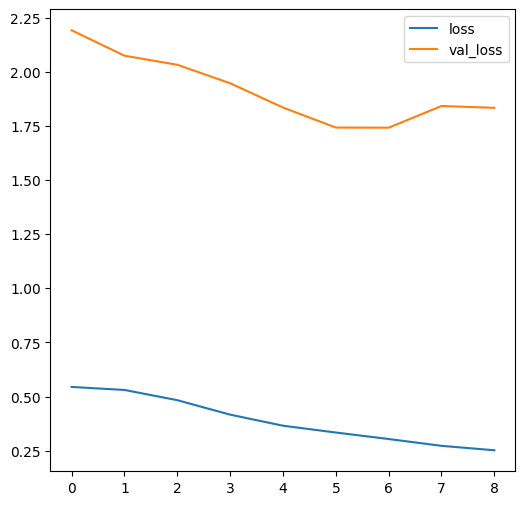

In [31]:
d[['loss','val_loss']].plot(figsize=(6,6))

In [32]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 45)              │           8,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 45)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,451 (146.30 KB)

 Trainable params: 12,483 (48.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,968 (97.54 KB)

In [33]:

y_pred

array([[0.83304495],
       [0.386973  ],
       [0.83527946],
       [0.389897  ],
       [0.83750904],
       [0.39281887],
       [0.8397322 ],
       [0.3957347 ],
       [0.84194744],
       [0.39864278],
       [0.8441682 ],
       [0.40156734],
       [0.84636796],
       [0.40446094],
       [0.84856826],
       [0.4073629 ],
       [0.850768  ],
       [0.4102696 ],
       [0.852963  ],
       [0.4131734 ],
       [0.8551502 ],
       [0.4160698 ],
       [0.8573267 ],
       [0.41895258],
       [0.859497  ],
       [0.42183083],
       [0.8616694 ],
       [0.42471954],
       [0.86383045],
       [0.42759353],
       [0.8659864 ],
       [0.43046516],
       [0.8681419 ],
       [0.43334165],
       [0.8702866 ],
       [0.43620348],
       [0.87242717],
       [0.43906412],
       [0.8745556 ],
       [0.44190854],
       [0.8766784 ],
       [0.44474944],
       [0.8788014 ],
       [0.44759807],
       [0.8809187 ],
       [0.45044124],
       [0.8830304 ],
       [0.453

In [34]:
y_pred.ndim

2

<Axes: >

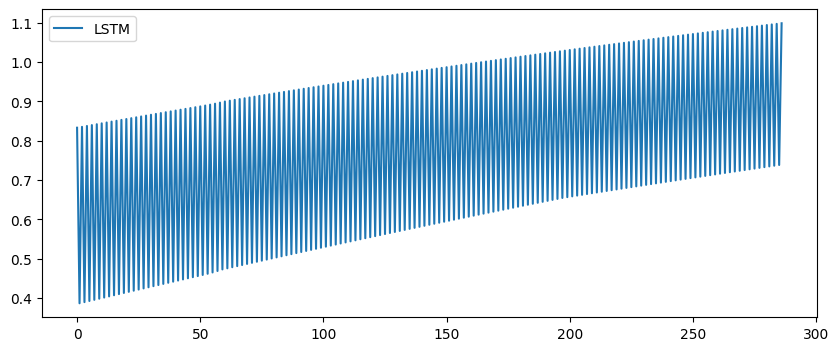

In [35]:

Pred = pd.DataFrame({"LSTM": y_pred.flatten()})  # flatten → 1D

Pred.head()


Pred.plot(figsize=(10,4))

In [36]:
print("y_pred.shape:", y_pred.shape)


y_pred.shape: (287, 1)


In [37]:
import os
from tensorflow.keras.models import save_model

folder = "models"
os.makedirs(folder, exist_ok=True)
model_path = os.path.join(folder, "model_LSTM_forex.h5")
model_LSTM.save(model_path)
print(f"Model saved to {model_path}")


Model saved to models\model_LSTM_forex.h5
